**Название проекта:**

Прогнозирование количества заказов такси.
____

**Цель исследования:**

Компания «ХХХ такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. 

***Задачи исследования:***

1. Загрузить данные и выполнить их ресемплирование по одному часу.
2. Проанализировать данные.
3. Сделать тестовую выборку размером 10% от исходных данных.
4. Обучить разные модели с различными гиперпараметрами. 
5. Проверить данные на тестовой выборке и сделать выводы. Значение метрики RMSE на тестовой выборке должно быть не больше 48.
6. Предложить модель для такого предсказания.

**Исходные данные:**

*    В распоряжении есть исторические <a href="https://code.s3.yandex.net/datasets/taxi.csv"> данные </a> о заказах такси в аэропортах.


***Описание данных:***

Таблица **taxi.csv** (исторические данные):

**Признаки:**

*    datetime — дата и время

**Целевой признак:**

*    num_orders - количество заказов

____

**Данное исследование разделим на несколько частей.**

<a href='#link_1'> ***Часть 1. Изучение общей информации и подготовка данных:***</a>

*   Изучение файлов с данными, получение общей информации, загрузка библиотек.
*   Поиск явных дубликатов
*   Нахождение пропусков поиск их причин.
*   Оценка типов данных
*   Выполнить ресемплирование по одному часу.


<a href='#link_2'> ***Часть 2. Анализ данных***</a>

<a href='#link_3'> ***Часть 3. Обучение моделей.***</a>

*    <a href='#link_3.1'>3.1 Подготовим признаки для обучения моделей.</a>
*    <a href='#link_3.2'>3.2 Обучение модели LinearRegression.</a>
*    <a href='#link_3.3'>3.3 Обучение модели RandomForestRegressor.</a>
*    <a href='#link_3.4'>3.4 Обучение модели LGBMRegressor.</a>

<a href='#link_4'> ***Часть 4. Тестирование моделей:***</a>

In [1]:
# ! pip install optuna

<a id='link_1'> </a>
## Откроем файл, изучим и подготовим данные

In [2]:
# Импортируем библиотеки
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import winsound

from statsmodels.tsa.seasonal import seasonal_decompose

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from lightgbm import LGBMRegressor

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import TimeSeriesSplit

import optuna
import time

from sklearn.metrics import mean_squared_error

STATE = np.random.RandomState(12345)

In [3]:
def sound():
    '''
    Функция для подачи звука.
    Нужно для сигнализации об окончании выполнения кода.
    '''
    duration = 1000 # миллисекунды
    freq = 440 # Гц
    winsound.Beep(freq, duration)

In [5]:
# Функция для получения первичной информации об исходных данных
def get_info(df):
    '''
    Функция для получения первичной информации об исходных данных:
       - типы данных,
       - количество пропусков,
       - кол-во дубликатов, 
       - характеристики числовых столбцов
    '''
    print(100 * "-")
    print('Общее описание полученных данных:')
    print(100 * "-")
    df.info()
    print(100 * "-")
    print('Описание количественных переменных:')
    print(100 * "-")    
    display(df.describe(datetime_is_numeric=True))
    print(100 * "-")
    print(f'Количество полных дубликатов в таблице = {df.duplicated().sum()}')

In [6]:
# Откроем данные из файла
df = pd.read_csv('https://code.s3.yandex.net/datasets/taxi.csv', parse_dates=[0])
df.head()

,datetime,num_orders
0,2018-03-01 00:00:00,9
1,2018-03-01 00:10:00,14
2,2018-03-01 00:20:00,28
3,2018-03-01 00:30:00,20
4,2018-03-01 00:40:00,32


In [7]:
# Посмотрим распределение количественных переменных
df.describe(datetime_is_numeric=True)

,datetime,num_orders
count,26496,"26,496.00"
mean,2018-05-31 23:55:00,14.07
min,2018-03-01 00:00:00,0.00
25%,2018-04-15 23:57:30,8.00
50%,2018-05-31 23:55:00,13.00
75%,2018-07-16 23:52:30,19.00
max,2018-08-31 23:50:00,119.00
std,NaN,9.21


In [8]:
# Проверим количество полных дубликатов в таблице
df.duplicated().sum()

0

In [9]:
# Посмотрим общее описание полученных данных:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26496 entries, 0 to 26495
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   datetime    26496 non-null  datetime64[ns]
 1   num_orders  26496 non-null  int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 414.1 KB


In [10]:
# Назначим столбец 'datetime' индексом
df.set_index('datetime', inplace=True)

In [11]:
# Отсортируем данные по индексу
df.sort_index(inplace=True)

In [12]:
# Произведем ресемплирование по одному часу
df = df.resample('1H').sum()

In [13]:
df.head()

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43


**Вывод:**

*    Импортировал библиотеки
*    Загрузил данные
*    Распознал столбец с датой и временем.
*    Проверил на дубликаты. Дубликатов нет
*    Проверил на пропуски. Пропусков нет
*    Перевел дату-время в индексы
*    Отсортировал дату-время.
*    Произвел ресемплирование данных по одному часу

<a id='link_2'> </a>
## Анализ данных

Проанализируем график распределения количества заказов


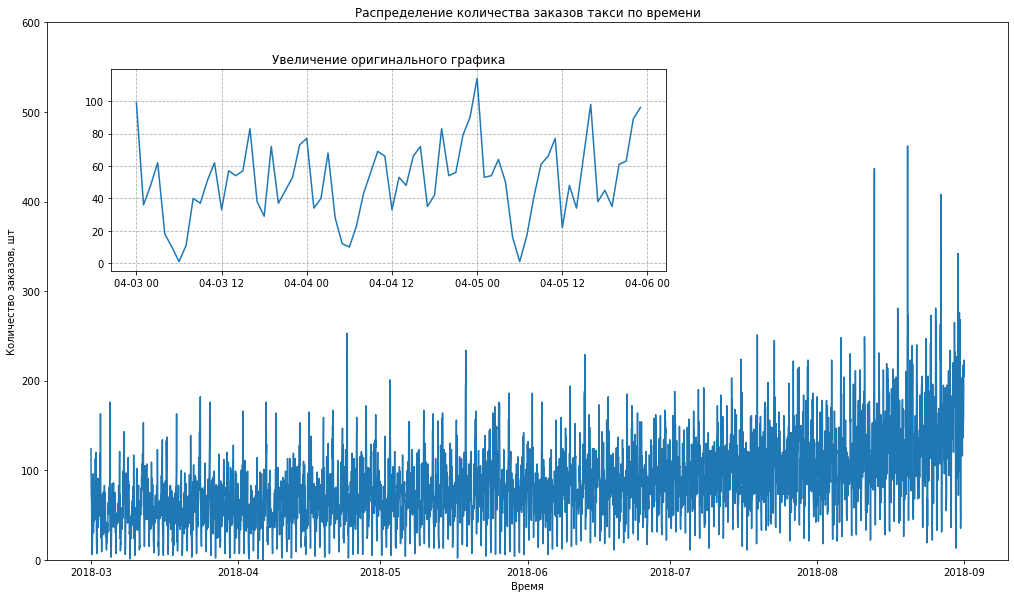

In [14]:
fig, ax = plt.subplots(figsize = (14,8))

# Добавим график распределения количества заказов такси по времени
ax.plot(df)
fig.tight_layout()
ax.set_ylim(0, 600)
ax.set_title('Распределение количества заказов такси по времени')
ax.set_xlabel('Время')
ax.set_ylabel('Количество заказов, шт')

# Добавим увеличенную часть графика
inset_ax = fig.add_axes([0.1, 0.55, 0.55, 0.35])

inset_ax.plot(df['2018-04-03':'2018-04-05'])
inset_ax.set_title('Увеличение оригинального графика')
inset_ax.grid(linestyle = '--', which='both')

plt.show()

По общему графику ничего не понятно, сделав увеличение до нескольких суток можно заметить, что есть посуточная зависимость.

Чтобы разобрать все зависимости разложим временной ряд на тренд и сезонную компоненту

In [15]:
# Разложим временной ряд на тренд и сезонную компоненту
# Произведем декомпозицию ряда
decomposed = seasonal_decompose(df)

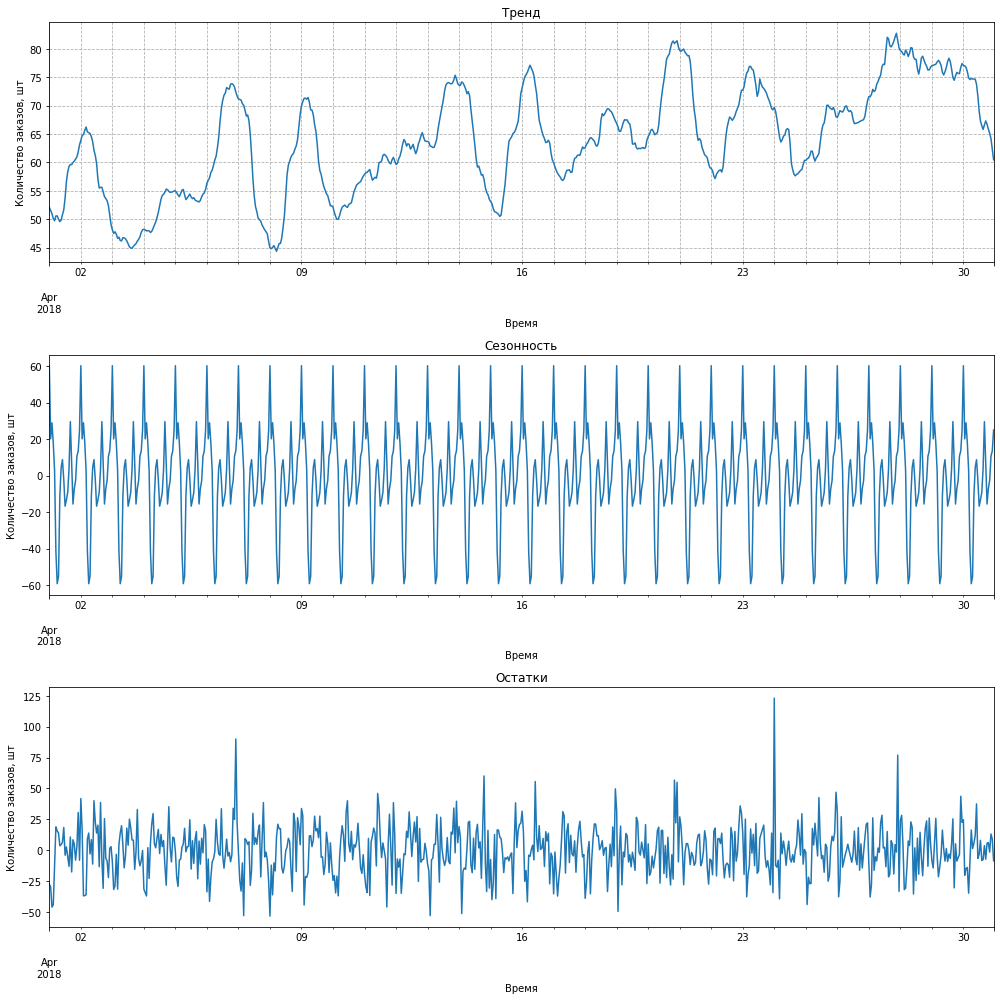

In [156]:
# Построим три графика на срезе за 1 месяц
plt.figure(figsize=(14, 14))

plt.subplot(311)
decomposed.trend['2018-04':'2018-04'].plot(ax=plt.gca())
plt.title('Тренд')
plt.xlabel('Время')
plt.ylabel('Количество заказов, шт')
plt.grid(linestyle = '--', which='both')

plt.subplot(312)
decomposed.seasonal['2018-04':'2018-04'].plot(ax=plt.gca())
plt.title('Сезонность')
plt.xlabel('Время')
plt.ylabel('Количество заказов, шт')

plt.subplot(313)
decomposed.resid['2018-04':'2018-04'].plot(ax=plt.gca())
plt.title('Остатки')
plt.xlabel('Время')
plt.ylabel('Количество заказов, шт')

plt.tight_layout()

**Вывод:**

На графике видно, что тренд связан с днями недели:

Пик в понедельник и субботу. Минимальная отметки в среду и в воскресенье.

Сезонность тоже имеет зависимость, но для ее изучения необходимо сделать увеличение в пределах нескольких суток.


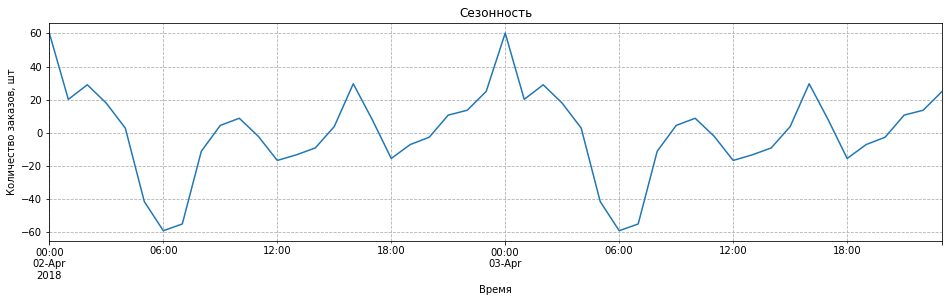

In [157]:
# Построим график сезонности в пределах 2х суток
plt.figure(figsize=(16, 4))
decomposed.seasonal['2018-04-02':'2018-04-03'].plot()

plt.title('Сезонность')
plt.xlabel('Время')
plt.ylabel('Количество заказов, шт')
plt.grid(linestyle = '--', which='both')

plt.show()

Пик заказов приходится начало суток/полночь(00:00). Минимум заказов приходится на 6:00.

    6:00 - суточный минимум заказа может быть обусловлен тем, что 'жаворонки' еще не проснулись, а 'совы' уже легли спать.
    9:00 - 10:00 - может быть обусловлено началом рабочего дня, люди приходят на работу, институт, школу.
    12:00 - спад заказов. Все доехали до работы. Обеденное время. 
    16:00 - следующий пик заказов. 
    17:00 - 18:00 - следующий спад.
    далее до 24:00 идет плавный рост заказов.

<a id='link_3'> </a>
## Обучение

Обучить разные модели с различными гиперпараметрами. Сделать тестовую выборку размером 10% от исходных данных.

In [158]:
def print_result(result, params = 0):
    '''
    Функция выводит на печать результаты работы модели
    result - словарь(имя модели, время обучения, Время предсказания, RMSE)
    params - гиперпараметры модели
    '''
    print('-' * 100)
    print(f'Для модели {result["model"]}')
    print(f'Гиперпараметры: {params}')
    print(f'RMSE = {result["rmse"]:.0f}')
    print(f'Время обучения: {result["learning_time"]:0.1f} секунд')
    print('-' * 100)

In [159]:
def optuna_hyper(name, objective):
    
    '''
    Подбор гиперпараметров OPTUNA
    На вход подается:
        name - название модели, например name=RandomForestRegressor
        objective - имя функции нужных входных параметров, например objective=objective_rfr
    '''
    # Add t0 - start time
    t0 = time.perf_counter()
    
    num_trials = 10  # more is better especially if num param is high and param range is also high.
    
    study = optuna.create_study(study_name=name, direction='maximize')
    study.optimize(objective, n_trials=num_trials) #, timeout=800)
    
    # Show the best params and score value
    print(f'best params: {study.best_params}')
    print('RMSE = {:.0f}'.format(-study.best_value))
    
    # Show worktime
    print(f'elapsed time: {time.perf_counter() - t0:0.1f}s')
    
    return study.best_params

<a id='link_3.1'> </a>

### Подготовим признаки для обучения моделей.

***Напишем функция для создания признаков путем получения:***

- календарных признаков
- отстающих значений
- скользящего среднего

In [160]:
def make_features(data, max_lag = 10, rolling_mean_size = 10, test_size = 0.25):
    '''
    Функция для создания признаков путем получения:
       - календарных признаков
       - отстающих значений
       - скользящего среднего
    '''
    data = data.copy()
    data.columns = ["target"]
    
    # Получение календарных признаков
    data['year'] = data.index.year
    data['month'] = data.index.month
    data['day'] = data.index.day
    data['dayofweek'] = data.index.dayofweek 
#     data['is_weekend'] = data['dayofweek'].isin([5,6])*1
    
    # Получение отстающих значений
    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data["target"].shift(lag)
    
    # Получение скользящего среднего
    data['rolling_mean'] = data["target"].shift().rolling(rolling_mean_size).mean() 
    
    # Удалим строки с пустыми значениями, образовавшиеся в результате получения новых признаков
    data = data.dropna()
    
#     # Сбросим индексы
#     data = data.reset_index(drop=True)
    
    # Разобъем выборку на тестовую и обучающую
    train, test = train_test_split(data, shuffle=False, test_size=test_size)
    
    # Разделим на признаки и целевой признак обучающую выборку
    target_train = train["target"]
    features_train = train.drop(["target"], axis=1)
    
    # Разделим на признаки и целевой признак тестовую выборку
    target_test = test['target']
    features_test = test.drop(["target"], axis=1)
    
    return features_train, features_test, target_train, target_test

**Произведем подбор значений 'lag' и 'roling' путем их перебора для модели LinearRegression()**

In [161]:
results = pd.DataFrame({'model':[0], 'lag':[0], 'roling':[0], 'rmse':[0]})

tscv = TimeSeriesSplit() # Кросс-валидатор для временных рядов

i = 0

for lag in range(1, 30):
    for roling in range(1, 30):
        features_train, features_test, target_train, target_test = make_features(df, 
            max_lag = lag, 
            rolling_mean_size = roling, 
            test_size = 0.10)
        model = LinearRegression()
        rmse = - cross_val_score(model, 
                                 features_train, target_train, 
                                 n_jobs=-1, cv=tscv, 
                                 scoring = 'neg_root_mean_squared_error'
                                ).mean()
        results.loc[i, 'model'] = str(model)
        results.loc[i, 'lag'] = lag
        results.loc[i, 'roling'] = roling
        results.loc[i, 'rmse'] = rmse
        i += 1

In [162]:
# Переведем тип столбцов 'lag' и 'roling' в тип 'int' 
results[['lag','roling']] = results[['lag','roling']].astype('int')

In [163]:
# Выведем первые 5 лучших строк по 'rmse'
results.sort_values('rmse').head()

,model,lag,roling,rmse
723,LinearRegression(),25,28,26.53
752,LinearRegression(),26,28,26.54
791,LinearRegression(),28,9,26.55
799,LinearRegression(),28,17,26.55
790,LinearRegression(),28,8,26.55


In [164]:
# Найдем медиану результатов по rmse и отсечем все, что выше данного значения
results_median = results['rmse'].median()

results = results.query('rmse <= @results_median')

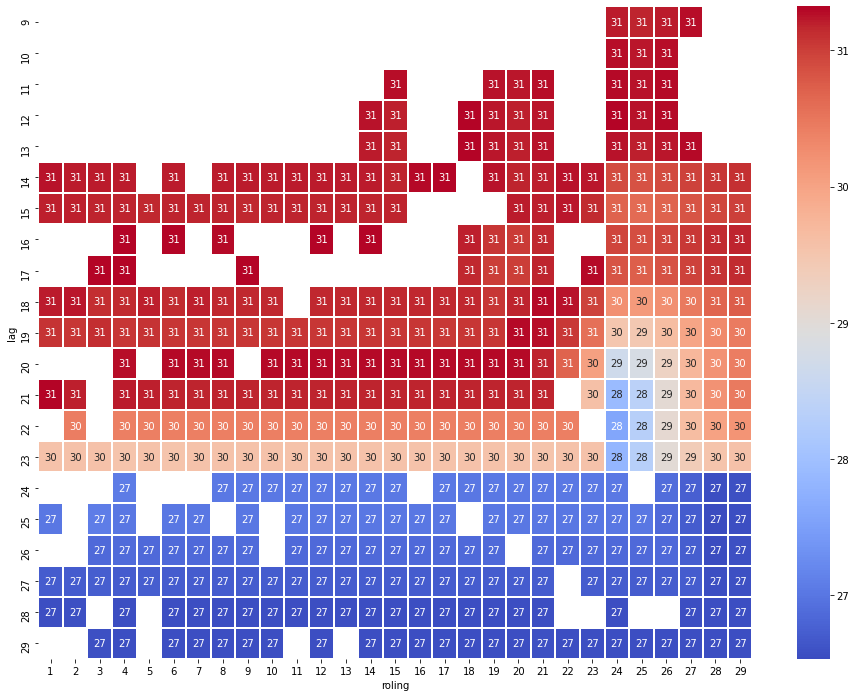

In [165]:
# Построим heatmap для оценки влияния значений 'lag' и 'roling' на качество модели
graf = results.pivot_table(values='rmse', index='lag', columns='roling')

plt.figure(figsize=(16,12))
sns.heatmap(graf, cmap='coolwarm',linecolor='white',linewidths=1, annot=True)
plt.show()

In [166]:
# Выберем первые 50 лучших строк по 'rmse' и построим гистограмму по каждому из параметров
graf1 = results.sort_values('rmse').head(50)

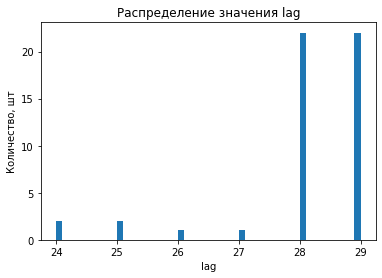

In [167]:
# Выведем график распределения значения lag
plt.hist(graf1['lag'], bins=50)
plt.title('Распределение значения lag')
plt.xlabel('lag')
plt.ylabel('Количество, шт')
plt.show()

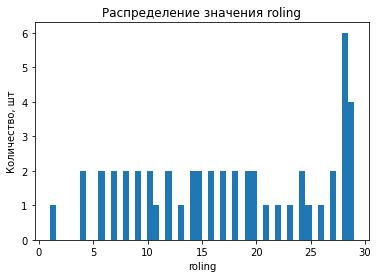

In [168]:
# Выведем график распределения значения roling
plt.hist(graf1['roling'], bins=50)
plt.title('Распределение значения roling')
plt.xlabel('roling')
plt.ylabel('Количество, шт')
plt.show()

**Вывод:**

1. lag

    Исследовав график heatmap мы видим резкое разграничение по значениям RMSE. При этом мы можем выбрать значение lag  более 23, чтобы значению RMSE < 28 (треть полученных значений)  
    Если же смотреть на распределение значений lag для лучших 50 значений rmse, то мы видим что они находятся в при значениях 28 и 29. Так что выберем значение равное 28
    

2. roling

    Судя по графику heatmap при значениях lag > 23, любое значение roling удовлетворяет значению RMSE < 28. При этом график распределения roling для лучших 50 значений rmse также имеет равномерное распределение. Но значение 28 больше значений. Поэтому выберем значение равное 28


In [169]:
lag = graf1['lag'].value_counts().reset_index()['index'][0]
roling = graf1['roling'].value_counts().reset_index()['index'][0]

In [170]:
print('lag = ', lag)
print('roling = ', roling)

lag =  28
roling =  28


In [171]:
# Получим дополнительные признаки, вызвав функцию 'make_features'
features_train, features_test, target_train, target_test = make_features(df, 
    max_lag = lag, 
    rolling_mean_size = roling, 
    test_size = 0.10)

<a id='link_3.2'> </a>

### Обучение модели LinearRegression.

In [172]:
# Напишем функцию для модели LinearRegression

def model_linear_regression(features_train, features_test, target_train, target_test):
        
    """
    Функция обучает модель по методу LinearRegression.
    На вход подается обучающий набор данных features_train, target_train.
    Также на вход подаются или валидационный набор данных features_valid, target_valid,
    или тестировочный набор данных features_test, target_test.
    На выходе функция выдает предсказания и RMSE модели.
    """
    t0 = time.perf_counter()
       
    model = LinearRegression()
    
    # Обучение модели
    model.fit(features_train, target_train)
    
    t1 = time.perf_counter()
    
    # Получение предсказаний
    prediction = model.predict(features_test)
    
    # Расчет RMSE
    rmse = mean_squared_error(target_test, prediction, squared=False)
    
    # Сбор результатов в словарь
    result = {'model': 'LinearRegression', 'learning_time': t1-t0, 'rmse': rmse}
    
    # Печать результатов при помощи функции
    print_result(result)
    
    return result, prediction

In [173]:
# Обучим модель LinearRegression на лучших параметрах
result_lr, prediction_lr = model_linear_regression(
    features_train, features_test, 
    target_train, target_test)

----------------------------------------------------------------------------------------------------
Для модели LinearRegression
Гиперпараметры: 0
RMSE = 46
Время обучения: 0.0 секунд
----------------------------------------------------------------------------------------------------


<a id='link_3.3'> </a>

### Подбор лучших гиперпараметров и обучение модели RandomForestRegressor

In [174]:
# Напишем функцию для модели RandomForestRegressor

def model_random_forest(features_train, features_test, target_train, target_test, params):
    
    """
    Функция обучает модель по методу RandomForestRegressor (Случайный лес).
    На вход подается обучающий набор данных features_train, target_train.
    Также на вход подаются или валидационный набор данных features_valid, target_valid,
    или тестировочный набор данных features_test, target_test.
    
    На выходе функция выдает RMSE модели и предсказания.
    """
    t0 = time.perf_counter()
    
    model = RandomForestRegressor(**params, random_state=STATE) 
    
    # Обучение модели
    model.fit(features_train, target_train)
    
    t1 = time.perf_counter()
    
    # Получение предсказаний
    prediction = model.predict(features_test)
    
    # Расчет RMSE
    rmse = mean_squared_error(target_test, prediction, squared=False)
    
    result = {'model': 'RandomForestRegressor', 'learning_time': t1-t0, 'rmse': rmse}
    
    print_result(result, params)
    
    return result, prediction

In [175]:
def objective_rfr(trial):
    '''
    RandomForestRegressor objective для OPTUNA
    '''
    param = {
        'n_estimators': trial.suggest_int("n_estimators", 20, 150), 
        'max_depth': trial.suggest_int("max_depth", 5, 13),
        'min_samples_split': trial.suggest_int("min_samples_split", 5, 13),
#         'min_samples_leaf': trial.suggest_int("min_samples_leaf", 5, 7),
#         'max_features': trial.suggest_categorical("max_features", ["auto", "sqrt"]),
#         'bootstrap': True,
        'random_state': STATE
    }
       
    clf = RandomForestRegressor(**param)
    
    tscv = TimeSeriesSplit() # Кросс-валидатор для временных рядов
    
    return cross_val_score(clf, features, target, n_jobs=-1, cv=tscv, scoring = 'neg_root_mean_squared_error').mean()

In [176]:
# Обозначим данные для функции подбора гиперпараметров features и target
features = features_train
target = target_train

In [177]:
# Подберем гиперпараметры для модели RandomForestRegressor
best_params_rfr = optuna_hyper(name='RFRegressor', objective=objective_rfr)

[I 2022-05-08 12:38:09,615] A new study created in memory with name: RFRegressor
[I 2022-05-08 12:38:14,307] Trial 0 finished with value: -26.40353758151295 and parameters: {'n_estimators': 101, 'max_depth': 8, 'min_samples_split': 9}. Best is trial 0 with value: -26.40353758151295.
[I 2022-05-08 12:38:17,636] Trial 1 finished with value: -26.226676658197402 and parameters: {'n_estimators': 67, 'max_depth': 9, 'min_samples_split': 6}. Best is trial 1 with value: -26.226676658197402.
[I 2022-05-08 12:38:21,344] Trial 2 finished with value: -26.433605771602707 and parameters: {'n_estimators': 82, 'max_depth': 8, 'min_samples_split': 12}. Best is trial 1 with value: -26.226676658197402.
[I 2022-05-08 12:38:24,546] Trial 3 finished with value: -26.031825018970643 and parameters: {'n_estimators': 54, 'max_depth': 12, 'min_samples_split': 11}. Best is trial 3 with value: -26.031825018970643.
[I 2022-05-08 12:38:29,792] Trial 4 finished with value: -25.957378303473696 and parameters: {'n_esti

best params: {'n_estimators': 85, 'max_depth': 13, 'min_samples_split': 7}
RMSE = 26
elapsed time: 40.5s


In [178]:
# Обучим модель RandomForestRegressor на лучших параметрах
result_rfr, prediction_rfr = model_random_forest(
    features_train, features_test, 
    target_train, target_test,
    best_params_rfr)

----------------------------------------------------------------------------------------------------
Для модели RandomForestRegressor
Гиперпараметры: {'n_estimators': 85, 'max_depth': 13, 'min_samples_split': 7}
RMSE = 45
Время обучения: 4.7 секунд
----------------------------------------------------------------------------------------------------


In [179]:
# sound()

<a id='link_3.4'> </a>

### Подбор лучших гиперпараметров и обучение модели LGBMRegressor

In [180]:
# Напишем функцию для модели LGBMRegressor

def model_lgbm_regressor(features_train, features_test, target_train, target_test, params):
    
    """
    Функция обучает модель по методу LGBMRegressor.
    На вход подается обучающий набор данных features_train, target_train.
    Также на вход подаются или валидационный набор данных features_valid, target_valid,
    или тестировочный набор данных features_test, target_test.
    
    На выходе функция выдает RMSE модели и предсказания.
    """
    t0 = time.perf_counter()
    
    model = LGBMRegressor(**params, random_state=STATE)
    
    # Обучение модели
    model.fit(features_train, target_train)
    
    t1 = time.perf_counter()
    
    # Получение предсказаний
    prediction = model.predict(features_test)    
   
    # Расчет RMSE
    rmse = mean_squared_error(target_test, prediction, squared=False)

    # Сбор результатов в словарь
    result = {'model': 'LGBMRegressor', 'learning_time': t1-t0, 'rmse': rmse}
    
    # Печать результатов при помощи функции    
    print_result(result, params)    
   
    return result, prediction

In [181]:
def objective_lgbmr(trial):
    '''
    LGBMRegressor objective for OPTUNA
    '''
    param = {
        'n_estimators': trial.suggest_int("n_estimators", 20, 150),
        'learning_rate': trial.suggest_float("learning_rate", 0.1, 0.6),
        'max_depth': trial.suggest_int("max_depth", 5, 13),
        'random_state': STATE
    }
       
    clf = LGBMRegressor(**param)   
    
    tscv = TimeSeriesSplit() # Кросс-валидатор для временных рядов
    
    return cross_val_score(clf, features, target, n_jobs=-1, cv=tscv, scoring = 'neg_root_mean_squared_error').mean()

In [182]:
# Обозначим данные для функции подбора гиперпараметров features и target
features = features_train
target = target_train

In [183]:
# Подберем гиперпараметры для модели LGBMRegressor
best_params_lgbmr = optuna_hyper(name='LGBMRegressor', objective=objective_lgbmr)

[I 2022-05-08 12:38:54,974] A new study created in memory with name: LGBMRegressor
[I 2022-05-08 12:38:57,966] Trial 0 finished with value: -25.86075462872239 and parameters: {'n_estimators': 110, 'learning_rate': 0.15335394299268187, 'max_depth': 6}. Best is trial 0 with value: -25.86075462872239.
[I 2022-05-08 12:38:58,812] Trial 1 finished with value: -25.871812364306994 and parameters: {'n_estimators': 70, 'learning_rate': 0.22372668778717, 'max_depth': 8}. Best is trial 0 with value: -25.86075462872239.
[I 2022-05-08 12:38:59,852] Trial 2 finished with value: -26.398385750544797 and parameters: {'n_estimators': 134, 'learning_rate': 0.236010858839885, 'max_depth': 7}. Best is trial 0 with value: -25.86075462872239.
[I 2022-05-08 12:39:00,476] Trial 3 finished with value: -25.78588410140579 and parameters: {'n_estimators': 67, 'learning_rate': 0.11305665644260363, 'max_depth': 11}. Best is trial 3 with value: -25.78588410140579.
[I 2022-05-08 12:39:01,018] Trial 4 finished with val

best params: {'n_estimators': 53, 'learning_rate': 0.13306767902838837, 'max_depth': 5}
RMSE = 26
elapsed time: 9.0s


In [184]:
# Обучим модель LGBMRegressor на лучших параметрах
result_lgbmr, prediction_lgbmr = model_lgbm_regressor(
    features_train, features_test, 
    target_train, target_test,    
    best_params_lgbmr)

----------------------------------------------------------------------------------------------------
Для модели LGBMRegressor
Гиперпараметры: {'n_estimators': 53, 'learning_rate': 0.13306767902838837, 'max_depth': 5}
RMSE = 42
Время обучения: 0.2 секунд
----------------------------------------------------------------------------------------------------


<a id='link_4'> </a>
## Тестирование

In [185]:
# Создадим словарь с готовыми ключами и пустыми списками в нем
results = {i: [] for i in result_rfr.keys()}
results

{'model': [], 'learning_time': [], 'rmse': []}

In [186]:
# Соберем все результаты в словарь 'results'
for result in [result_lr, result_rfr, result_lgbmr]:
    for key, value in result.items():
        results[key].append(value)
results

{'model': ['LinearRegression', 'RandomForestRegressor', 'LGBMRegressor'],
 'learning_time': [0.010714999999891006,
  4.726219000000128,
  0.18602319999990868],
 'rmse': [46.48897059071949, 45.01367295465203, 41.815619146348965]}

In [187]:
# Соберем результаты в таблицу
results = pd.DataFrame(results)
results

,model,learning_time,rmse
0,LinearRegression,0.01,46.49
1,RandomForestRegressor,4.73,45.01
2,LGBMRegressor,0.19,41.82


In [228]:
# Соберем предсказания и целевой признак в одну таблицу
result_graph = pd.DataFrame({
    'target_test': target_test,
    'LinearRegression': prediction_lr, 
    'LGBMRegressor': prediction_lgbmr,
    'RandomForestRegressor': prediction_rfr
}, index = target_test.index)

result_graph.head()

,target_test,LinearRegression,LGBMRegressor,RandomForestRegressor
datetime,,,,
2018-08-13 17:00:00,152,98.68,136.91,139.02
2018-08-13 18:00:00,104,108.03,98.76,102.11
2018-08-13 19:00:00,91,84.54,101.29,105.25
2018-08-13 20:00:00,82,75.63,104.35,102.26
2018-08-13 21:00:00,160,100.31,118.92,115.26


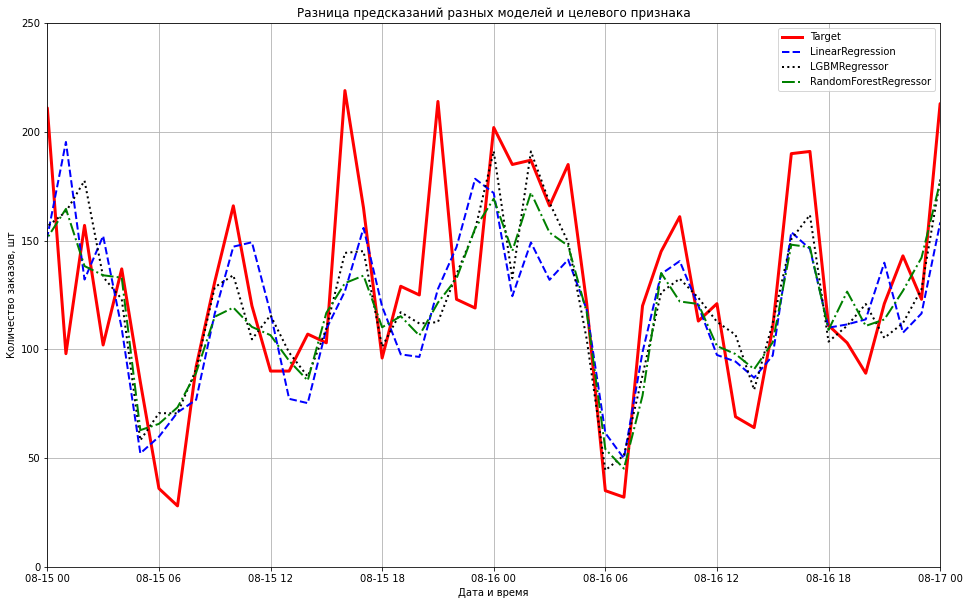

In [229]:
# Построим предсказания разных моделей и целевой признак на одном графике.

plt.figure(figsize = (16,10))
plt.plot(result_graph['target_test'], color='red', lw=3, ls='-', label='Target')
plt.plot(result_graph['LinearRegression'], color='blue', lw=2, ls='--', label='LinearRegression')
plt.plot(result_graph['LGBMRegressor'], color='black', lw=2, ls=':', label='LGBMRegressor')
plt.plot(result_graph['RandomForestRegressor'], color='green', lw=2, ls='-.', label='RandomForestRegressor')

plt.title('Разница предсказаний разных моделей и целевого признака')
plt.xlabel('Дата и время')
plt.ylabel('Количество заказов, шт')

plt.xlim([pd.to_datetime('2018-08-15 00:00:00'), pd.to_datetime('2018-08-17 00:00:00')])
plt.ylim(0, 250)
plt.grid('both')
plt.legend()

plt.show()

In [ ]:
plt.figure(figsize = (16,10))
plt.plot(result['target'], color='green', lw=2, ls='-', label='Target')
plt.plot(result['prediction'], color='red', lw=3, ls='--', label='Prediction')

plt.title('Название')
plt.xlabel('Ось Х')
plt.ylabel('Ось Y')

# Выбираешь интервал для увеличения, чтобы наглядно было
plt.xlim([pd.to_datetime('2018-08-15 00:00:00'), pd.to_datetime('2018-08-17 00:00:00')]) 
plt.ylim(0, 250)
plt.grid('both')
plt.legend()

plt.show()

**Вывод:**

Лучший показатель rmse показала модель LGBMRegressor, также время обучения также не самое высокое. Рекомендуется к использованию.

По графику видно, что некоторые пики не предсказывают модели. Для их более точного предсказания возможно нужно дополнительно углубиться в анализ и подготовку признаков.